# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow, inspired by the [Evol Instruct](https://arxiv.org/abs/2304.12244) paper.



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

In [1]:
!pip install -qU langsmith langchain-core langchain-community langchain-openai langchain-qdrant

In [2]:
!pip install -qU pymupdf ragas

We'll need to provide our LangSmith API key, and set tracing to "true".

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Task 2: Loading Source Documents

In order to create a synthetic dataset, we must first load our source documents!

In [7]:
from langchain_community.document_loaders import PyMuPDFLoader

documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

## Task 3: Generate Synthetic Data

Let's first take a peek under the RAGAS hood to see what's happening when we generate a single example.

For simplicities sake - we'll look at a flow that results in a reasoning question.

### Two LLMs To Rule Them All

- `generator_llm` - will generate our seed questions and evolutions
- `critic_llm` - will act as a critic to verify if the evolutions are as we expect them to be

### Entering the Generation

We'll enter the generation process with our `generate_with_langchain_docs()` method - let's look at how that is implemented:

```python
def generate_with_langchain_docs(
    self,
    documents: t.Sequence[LCDocument],
    test_size: int,
    distributions: t.Optional[Distributions] = None,
    with_debugging_logs=False,
    is_async: bool = True,
    raise_exceptions: bool = True,
    run_config: t.Optional[RunConfig] = None,
):
    distributions = distributions or {}
    # chunk documents and add to docstore
    self.docstore.add_documents(
        [Document.from_langchain_document(doc) for doc in documents]
    )

    return self.generate(
        test_size=test_size,
        distributions=distributions,
        with_debugging_logs=with_debugging_logs,
        is_async=is_async,
        raise_exceptions=raise_exceptions,
        run_config=run_config,
    )
```

As you can see - before we do anything, our `doctore` is created using the provided `documents`.

Then, we move on to `generate()`, let's see how that works next!

### Generating Examples!

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/generator.py#L234), we'll work through the pseudo-code.

```python
function generate(test_size, distributions, other_params...):
    # Validate and set default values
    if distributions not provided:
        distributions = DEFAULT_DISTRIBUTION
    
    validate_distributions_sum_to_one(distributions)
    
    set_up_run_config()
    initialize_docstore()
    
    # Initialize evolutions
    for each evolution in distributions:
        initialize_evolution(evolution)
    
    set_up_debugging_logs_if_needed()
    
    # Set up execution environment
    executor = create_executor()
    
    # Get initial nodes
    current_nodes = get_random_nodes_from_docstore(test_size)
    
    total_evolutions = 0
    
    # Distribute evolutions based on probabilities
    for each evolution, probability in distributions:
        num_samples = round(probability * test_size)
        for i in random_sample(range(test_size), num_samples):
            submit_task_to_executor(evolution.evolve, current_nodes[i])
            total_evolutions += 1
    
    # Add filler evolutions if needed
    while total_evolutions < test_size:
        random_evolution = choose_random_evolution(distributions)
        submit_task_to_executor(random_evolution.evolve, current_nodes[total_evolutions])
        total_evolutions += 1
    
    # Get results
    try:
        test_data_rows = executor.get_results()
        if test_data_rows is empty:
            raise Exception("No results generated")

    return test_data_rows
```

In essence, we:

1. Do some validation of inputs, and initialize our evolutions.
2. Get some random nodes from our docstore.
3. Evolve the current nodes based on the desired distribution.
4. Fill with sampled evolutions if we're not at the desired number of rows.

### Peeking into the Complex Evolution Implementation for Reasoning Questions.

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L375). We'll work through the high-level implementation below.

Let's look into how the "Complex Evolution" is implemented:

1. First, we use [`_aevolve()`](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L289) to generate a "Seed Question".

```python
simple_question, current_nodes, _ = await self.se._aevolve(
            current_tries, current_nodes
        )
```

2. We use our provided `question_prompt` to generate a reasoning question.

```python
result = await self.generator_llm.generate(
            prompt=question_prompt.format(
                question=simple_question, context=merged_node.page_content
            )
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L15)):

```python
instruction="""Complicate the given question by rewriting question into a multi-hop reasoning question based on the provided context.
    Answering the question should require the reader to make multiple logical connections or inferences using the information available in given context.
    Rules to follow when rewriting question:
    1. Ensure that the rewritten question can be answered entirely from the information present in the contexts.
    2. Do not frame questions that contains more than 15 words. Use abbreviation wherever possible.
    3. Make sure the question is clear and unambiguous.
    4. phrases like 'based on the provided context','according to the context',etc are not allowed to appear in the question."""
```

3. We verify the question is valid.

```python
is_valid_question, feedback = await self.question_filter.filter(
            reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L390))

```python
instruction="""
Asses the given question for clarity and answerability given enough domain knowledge, consider the following criteria:
1.Independence: Can the question be understood and answered without needing additional context or access to external references not provided within the question itself? Questions should be self-contained, meaning they do not rely on specific documents, tables, or prior knowledge not shared within the question.
2.Clear Intent: Is it clear what type of answer or information the question seeks? The question should convey its purpose without ambiguity, allowing for a direct and relevant response.
Based on these criteria, assign a verdict of "1" if a question is specific, independent, and has a clear intent, making it understandable and answerable based on the details provided. Assign "0" if it fails to meet one or more of these criteria due to vagueness, reliance on external references, or ambiguity in intent.
Provide feedback and a verdict in JSON format, including suggestions for improvement if the question is deemed unclear. Highlight aspects of the question that contribute to its clarity or lack thereof, and offer advice on how it could be reframed or detailed for better understanding and answerability.
"""
```

4. We [handle the question](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L401) if it's not valid, otherwise we compress the question:

```python
compressed_question = await self._transform_question(
            prompt=self.compress_question_prompt, question=reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L100))

```python
instruction="""Rewrite the following question to make it more indirect and shorter while retaining the essence of the original question.
    The goal is to create a question that conveys the same meaning but in a less direct manner. The rewritten question should shorter so use abbreviation wherever possible."""
```

5. Filter the newly compressed question based on a comparison to the original simple question.

```python
if await self.evolution_filter.filter(simple_question, compressed_question):
            # retry
            current_nodes = self.se._get_new_random_node()
            logger.debug(
                "evolution_filter failed, retrying with %s", len(current_nodes.nodes)
            )
            return await self.aretry_evolve(current_tries, current_nodes)
```

`filter` is implemented as follows, with our Critic LLM:

```python
    async def filter(self, simple_question: str, compressed_question: str) -> bool:
        prompt = self.evolution_elimination_prompt.format(
            question1=simple_question, question2=compressed_question
        )
        results = await self.llm.generate(prompt=prompt)
        results = results.generations[0][0].text.strip()
        results = await evolution_elimination_parser.aparse(results, prompt, self.llm)
        results = results.dict() if results is not None else {}
        logger.debug("evolution filter: %s", results)
        return results.get("verdict") == 1
```

Let's zoom back out now!



### Generating Answers:

For answer generation, we simply ask the LLM to answer the question we evolved using the context associated with our evolution - that's it!

We will this:

```python
class AnswerFormat(BaseModel):
    answer: str
    verdict: int
```

Using [this prompt](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L143):

```python
instruction="""Answer the question using the information from the given context. Output verdict as '1' if answer is present '-1' if answer is not present in the context."""
```

This uses our Generator LLM.

Actually creating our Synthetic Dataset is as simple as running the following cell!

In [9]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

#### ❓ Question #1:

What do the distributions do *specifically*?

> NOTE: More information is available [here](https://docs.ragas.io/en/latest/concepts/testset_generation.html#in-depth-evolution) on the evolution distributions.

**ANSWER**

From the Ragas documenter here - https://docs.ragas.io/en/latest/concepts/testset_generation.html#in-depth-evolution:

- **Reasoning:** Rewrite the question in a way that enhances the need for reasoning to answer it effectively.
- **Conditioning:** Modify the question to introduce a conditional element, which adds complexity to the question.
- **Multi-Context:** Rephrase the question in a manner that necessitates information from multiple related sections or chunks to formulate an answer.

So, the distributions  result in a different being to the LLM that is generating the response shown to the user.  

Let's generate!

> NOTE: This cell will take some time, and also make a lot of calls to OpenAI's endpoints! You may run into rate-limits during this cell!

In [10]:
testset = generator.generate_with_langchain_docs(documents, 20, distributions, with_debugging_logs=True)

Filename and doc_id are the same for all nodes.                 
Generating:   0%|          | 0/20 [00:00<?, ?it/s][ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 2, 'structure': 3, 'relevance': 3, 'score': 2.75}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Certifications of Chief Executive Officer and Chief Financial Officer', 'Sarbanes-Oxley Act of 2002', 'Form 10-Q', 'Financial condition and results of operations', 'Section 906']
[ragas.testset.filters.DEBUG] context scoring: {'clarity': 2, 'depth': 2, 'structure': 3, 'relevance': 3, 'score': 2.5}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Apple Inc.', 'Consolidated statements of comprehensive income', 'Net income', 'Other comprehensive income', 'Derivative instruments']
[ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 3, 'structure': 3, 'relevance': 3, 'score': 3.0}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Net sales by category', '

#### 🏗️ Activity #1:

Using the dubgging logs above - trace through a single example of an evolution.

Mark which LLM (Generator, or Critic) was responsible for each step.

**ANSWER**

I don't fully understand the logs, but I think the general flow is that the generator LLM creates a seed question using the provided documents along with an answer.  The critic LLM analzyes both the question and the answer.  Based on the analysis, additional questons are generated until the scoring metrics are at the correct level. 

| Log                                                          | LLM       |
| ------------------------------------------------------------ | --------- |
| [ragas.testset.evolutions.INFO] seed question generated: What is the total other comprehensive income for Apple Inc. in the third quarter of 2024? | generator |
| [ragas.testset.filters.DEBUG] context scoring: {'clarity': 1, 'depth': 2, 'structure': 2, 'relevance': 3, 'score': 2.0} | critic    |
| [ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Adjusted Cost', 'Unrealized Gains', 'Unrealized Losses', 'Marketable Securities', 'Fair Value'] | critic ?  |
| [ragas.testset.filters.DEBUG] filtered question: {'feedback': "The question asks for a specific figure regarding unrealized losses reported in a financial statement for a particular date (September 30, 2023). However, it assumes access to the financial statement without providing any details or context about which financial statement is being referred to (e.g., a specific company's report). This reliance on external documents makes the question less independent and potentially unclear for those who do not have access to the relevant financial statement. To improve clarity and answerability, the question could specify the entity or organization whose financial statement is being referenced, or it could provide a brief context about the nature of the unrealized losses in question.", 'verdict': 0} | Critic    |



In [9]:
testset.to_pandas()

question  \
0   How do new product introductions impact Apple'...   
1   How does the Company evaluate changes in inter...   
2   What is included in Apple Inc.'s Form 10-Q for...   
3   What is the role of disclosure controls and pr...   
4   How do new product introductions impact Apple'...   
5   What disclosures are required regarding market...   
6   What is the role of disclosure controls and pr...   
7   What is included in Apple Inc.'s Form 10-Q und...   
8   How did iPhone net sales perform during the th...   
9   What is the significance of vendor non-trade r...   
10  How does the Company manage risks from forex a...   
11  How could risk awareness affect the Company's ...   
12  How does Apple use equity securities in share ...   
13  What exhibits in Form 10-Q for Apple Inc. rela...   
14  What factors influenced the change in net sale...   
15  How do Maestri and Cook ensure financial repor...   
16  Which part of Apple Inc.'s Form 10-Q analyzes ...   
17  What role does Luca Maestri have in Apple Inc....   

                                             contexts  \
0   [Item 2. \nManagement’s Discussion and Analysi...   
1   [Segment Reporting\nIn November 2023, the FASB...   
2   [Apple Inc.\nForm 10-Q\nFor the Fiscal Quarter...   
3   [Exhibit 31.2\nCERTIFICATION\nI, Luca Maestri,...   
4   [Item 2. \nManagement’s Discussion and Analysi...   
5   [Segment Reporting\nIn November 2023, the FASB...   
6   [Exhibit 31.2\nCERTIFICATION\nI, Luca Maestri,...   
7   [Apple Inc.\nForm 10-Q\nFor the Fiscal Quarter...   
8   [Products and Services Performance\nThe follow...   
9   [Interest Rate Risk\nTo protect the Company’s ...   
10  [ of reasons, including accounting considerati...   
11  [ ended March 30, 2024 (the “second quarter 20...   
12  [Item 2. \nUnregistered Sales of Equity Securi...   
13  [Item 6. \nExhibits\nIncorporated by Reference...   
14  [Segment Operating Performance\nThe following ...   
15  [Exhibit 31.2\nCERTIFICATION\nI, Luca Maestri,...   
16  [Apple Inc.\nForm 10-Q\nFor the Fiscal Quarter...   
17  [Exhibit 31.2\nCERTIFICATION\nI, Luca Maestri,...   

                                         ground_truth evolution_type  \
0   New product and service introductions can sign...         simple   
1   The Company evaluates changes in internal cont...         simple   
2   The answer to given question is not present in...         simple   
3   The answer to given question is not present in...         simple   
4   New product and service introductions can sign...         simple   
5   The answer to given question is not present in...         simple   
6   The answer to given question is not present in...         simple   
7   The Form 10-Q for Apple Inc. includes 'Managem...         simple   
8   iPhone net sales were relatively flat during t...         simple   
9   The significance of vendor non-trade receivabl...         simple   
10  The Company manages risks from foreign exchang...  multi_context   
11  When any one or more of the risks disclosed in...  multi_context   
12  Apple uses equity securities in share buybacks...  multi_context   
13  Exhibit 31.1 and Exhibit 31.2 in Form 10-Q for...  multi_context   
14  Americas net sales increased during the third ...  multi_context   
15  Maestri and Cook ensure financial reporting ac...  multi_context   
16  Management’s Discussion and Analysis of Financ...      reasoning   
17  Luca Maestri is the Senior Vice President and ...      reasoning   

                                             metadata  episode_done  
0   [{'source': 'https://s2.q4cdn.com/470004039/fi...          True  
1   [{'source': 'https://s2.q4cdn.com/470004039/fi...          True  
2   [{'source': 'https://s2.q4cdn.com/470004039/fi...          True  
3   [{'source': 'https://s2.q4cdn.com/470004039/fi...          True  
4   [{'source': 'https://s2.q4cdn.com/470004039/fi...          True  
5   [{'source': 'https://s2.q4cdn.com/470004039/fi...          True  
6   [{'source': 'h

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [11]:
from langsmith import Client

client = Client()

dataset_name = "Apple 10-Q Filing Questions - v3"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about Apple's 10-Q Filing"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [12]:
for test in testset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": test[1]["question"]
      },
      outputs={
          "answer": test[1]["ground_truth"]
      },
      metadata={
          "context": test[0]
      },
      dataset_id=dataset.id
  )

## Basic RAG Chain

Time for some RAG!

We'll use the Apple 10-Q filing as our data source today!


In [13]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [15]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [16]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q"
)

In [17]:
retriever = vectorstore.as_retriever()

To get the "A" in RAG, we'll provide a prompt.

In [18]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [20]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [21]:
rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

"I don't know."

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [22]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [23]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        }
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        }
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

## LangSmith Evaluation

In [25]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain"},
)

View the evaluation results for experiment: 'large-chef-86' at:
https://smith.langchain.com/o/be600afd-3795-5505-ad50-068c806b5628/datasets/6ffa739f-6876-4560-8248-5dc974f5722d/compare?selectedSessions=62dadf74-bcbd-4009-8bf4-e8b1dbf96ee5




15it [00:18,  1.25s/it]


<ExperimentResults large-chef-86>

## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [26]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [27]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

**ANSWER**

The context retrieved from the vector store will be very different if we are using a larger chunk size.  Since that context is used in our prompt, the answer generated by the LLM will be different. 

In [29]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

**ANSWER**

It's the same answer as above - the context retrievd during retrieval will change!  

In [30]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q (Augmented)"
)

In [31]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [32]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [33]:
dope_rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

"Yo, based on the context, Apple seems to be cruising just fine! Their net income for the nine months ended June 29, 2024, is a solid $79 billion, up from $74 billion the previous year. Plus, their operating income is looking sharp at $93.6 billion. Cash flows from operating activities are rolling in at $91.4 billion. While their total assets dipped a bit, they're still sitting on a hefty $331.6 billion. Overall, they’re flexing some serious financial muscle! 💪🍏"

Finally, we can evaluate the new chain on the same test set!

In [35]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'virtual-smile-69' at:
https://smith.langchain.com/o/be600afd-3795-5505-ad50-068c806b5628/datasets/6ffa739f-6876-4560-8248-5dc974f5722d/compare?selectedSessions=e4debd64-b7a2-474a-8792-4d2b06d5fbeb




3it [00:15,  3.90s/it]Error running evaluator <DynamicRunEvaluator evaluate> on run 6f8c32f8-3354-427a-a4fb-f908fc6dd91c: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-KmfGrNO5qeOaH1J78j9LtgyK on tokens per min (TPM): Limit 10000, Used 9958, Requested 315. Please try again in 1.638s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "/opt/anaconda3/envs/aie4/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1323, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/aie4/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 327, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/opt/anaconda3/envs/aie4/lib/python3.11/site-packages/langsmith/run_helpers.py

<ExperimentResults virtual-smile-69>

#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

**ANSWER**

We made three changes that improved our evaluation:

1. Increased chunk size
2. Changed embedding model
3. Changed prompt

Correctness

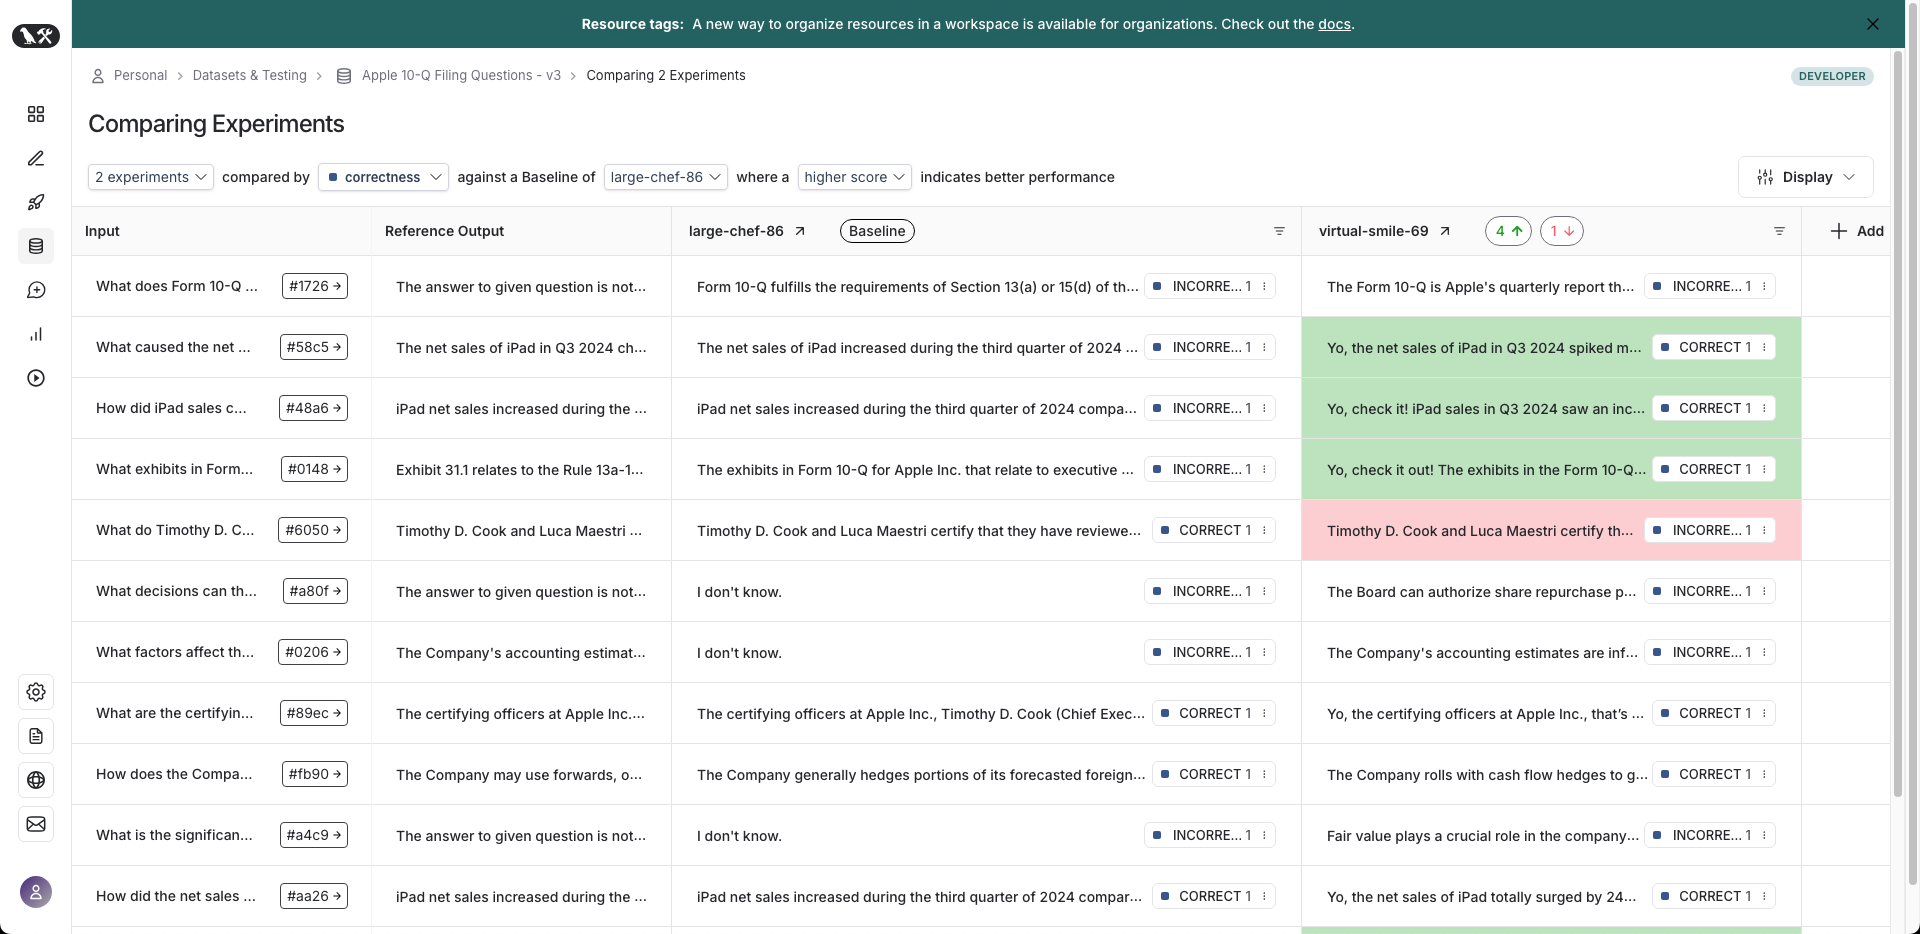

Dopeness

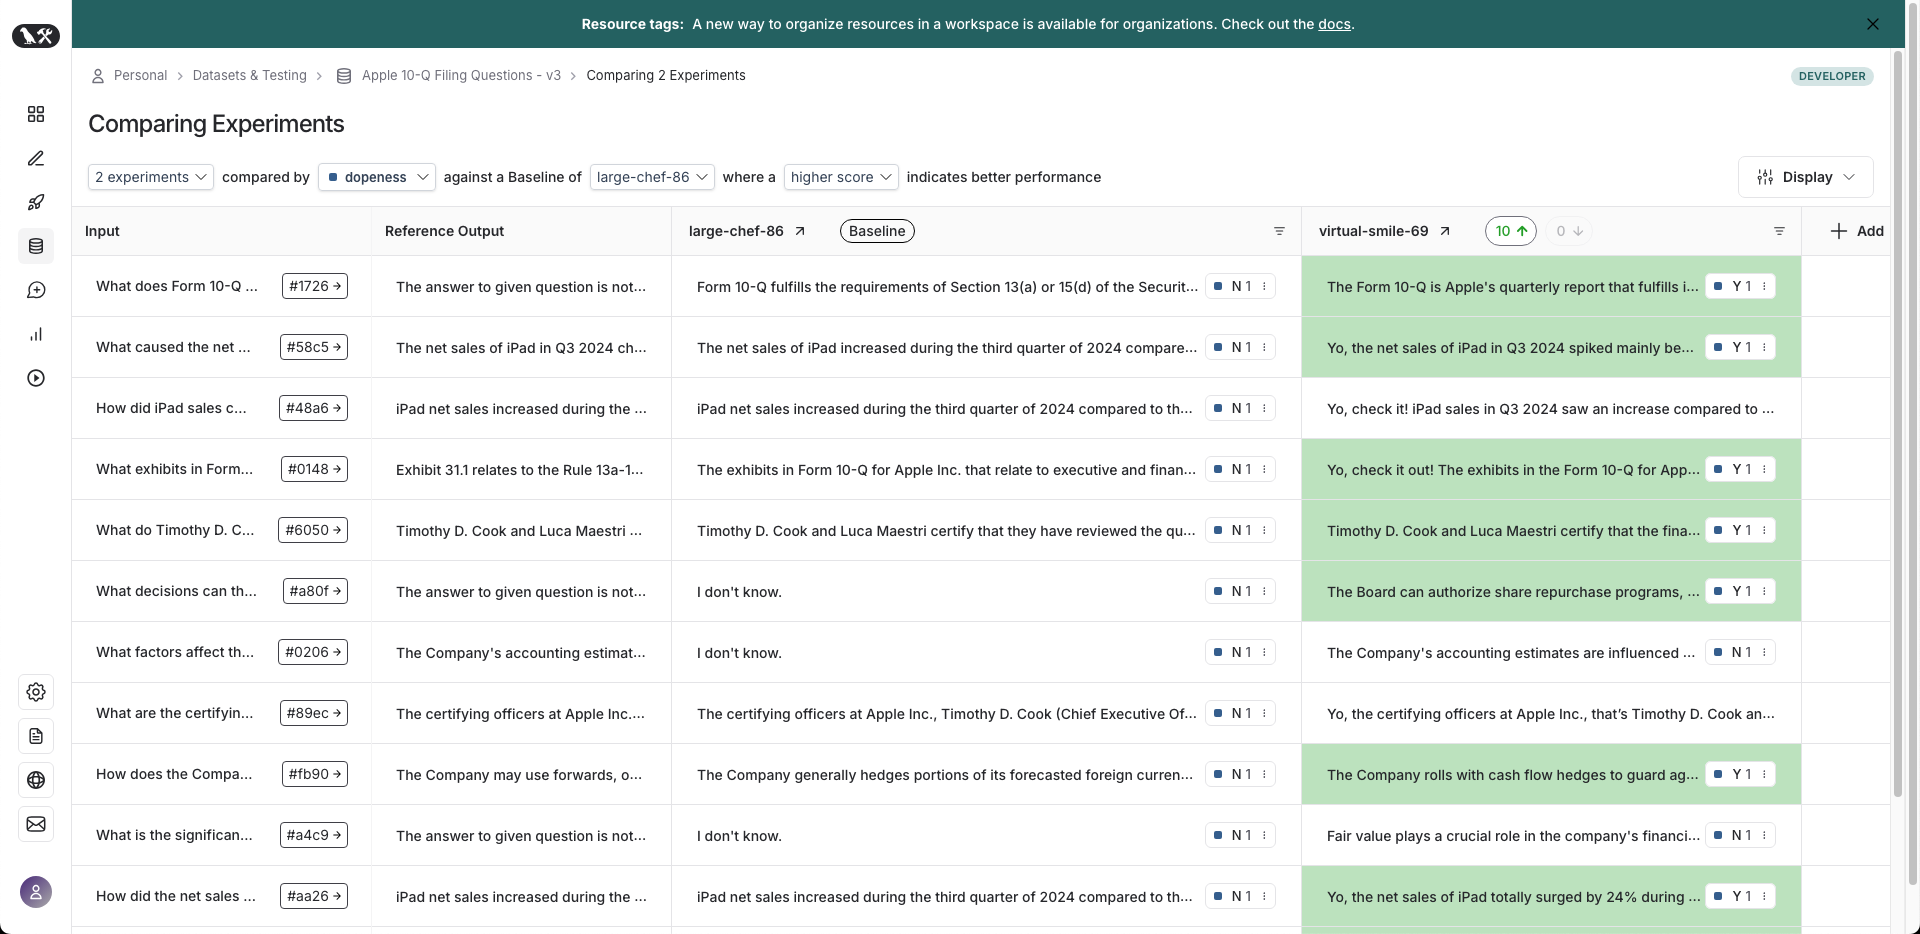

Helpfulness

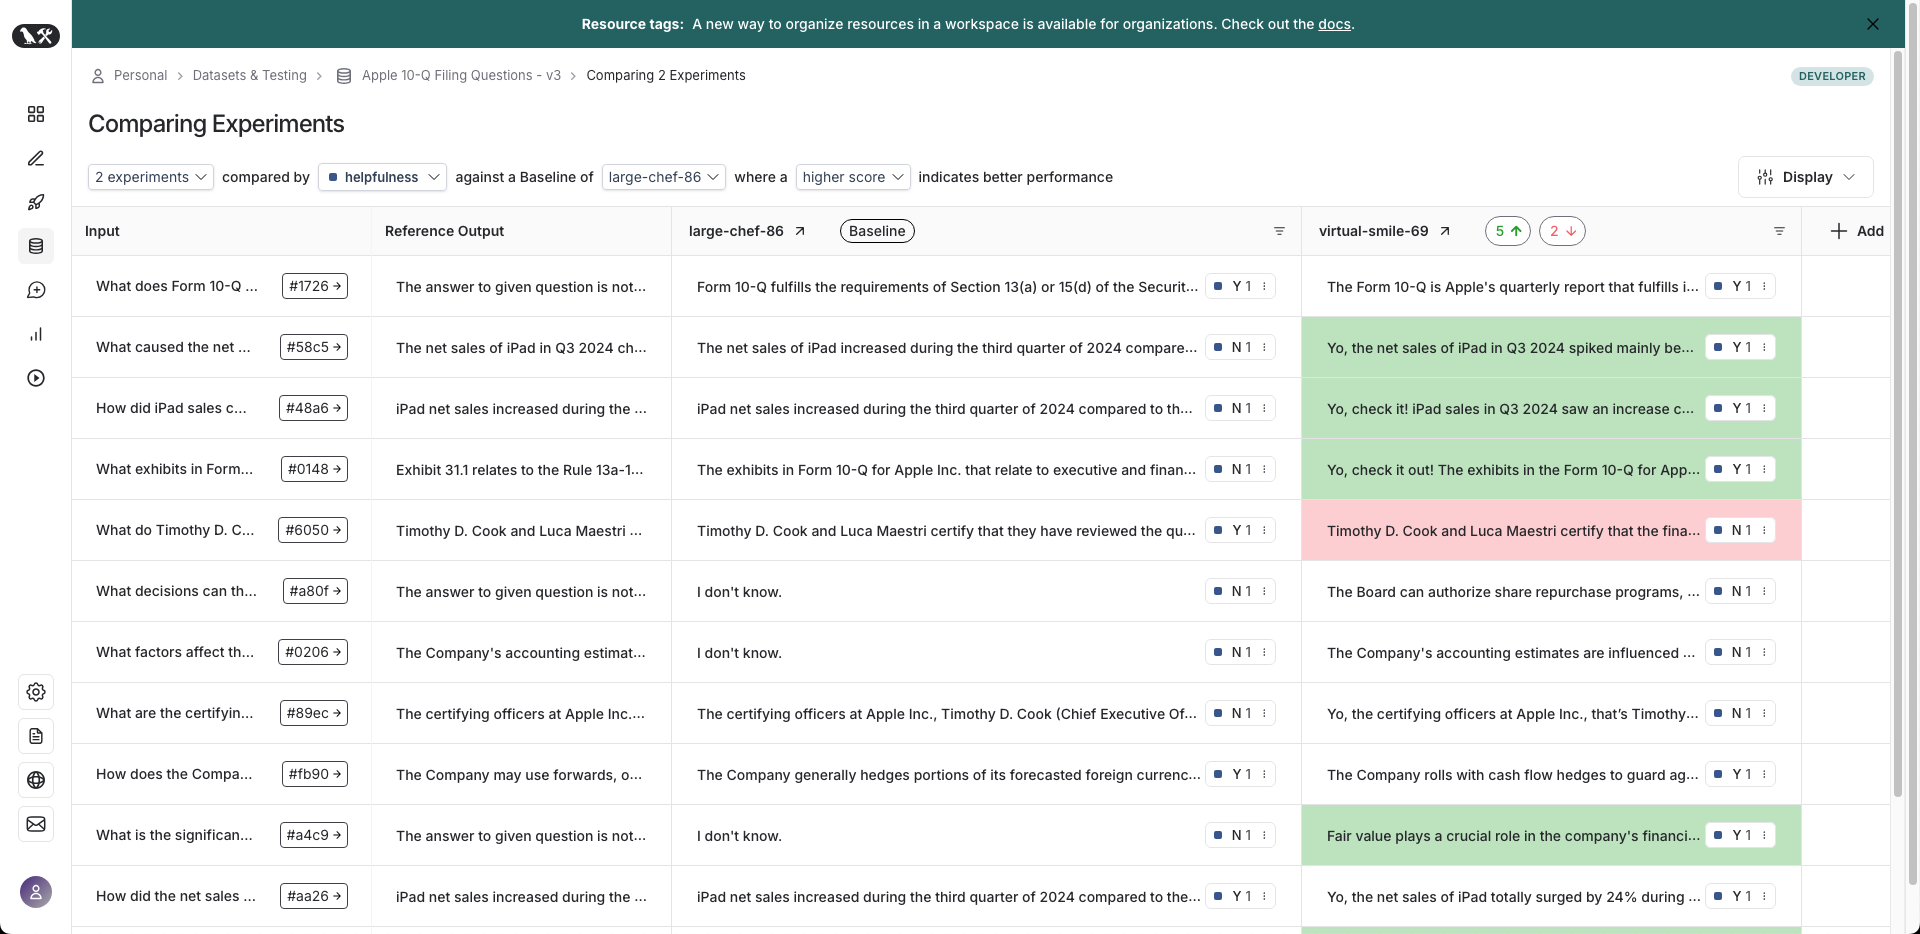